In [1]:
import keras.backend as K
from keras.models import Model, load_model
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D
from keras.layers import AveragePooling2D, concatenate, Input, Lambda, Cropping2D, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D
from keras.layers import concatenate, Reshape
from keras import utils
from keras.callbacks import Callback, LambdaCallback, EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler, ReduceLROnPlateau
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras.layers.normalization import BatchNormalization
from keras.applications.mobilenet import MobileNet, preprocess_input
import numpy as np
import pandas as pd
import cv2
import csv
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import glob

Using TensorFlow backend.


In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# here, I am basing my network off the previous vgglike model, 
# but the output of conv block1 is also fed into the fully connected layer
def mscnn(n_classes,input_shape, ksize=(3,3), dropout=0.25):
    inputs = Input(shape=input_shape)
    block1 = Conv2D(32, kernel_size=ksize, activation='relu', padding='same', name='set1_conv1')(inputs)
    block1 = BatchNormalization()(block1)
    block1 = Conv2D(32, kernel_size=ksize, activation='relu', padding='same', name='set1_conv2')(block1)
    block1 = BatchNormalization()(block1)
    block1 = MaxPooling2D(pool_size=(2, 2),strides=(2, 2), name='set1_pool')(block1)
    
    block2 = Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv1')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv2')(block2)
    block2 = BatchNormalization()(block2)
    block2 = Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv3')(block2)
    block2 = BatchNormalization()(block2)
    block2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2),name='set2_pool')(block2)
    output2 = Flatten()(block2)
    
    output1 = Flatten()(block1)
    
    merged = concatenate([output1, output2])
    
    fcblock = Dense(1024, activation='relu', name='fc1')(merged)
    fcblock = BatchNormalization()(fcblock)
    fcblock = Dropout(dropout)(fcblock)
    fcblock = Dense(512, activation='relu' , name='fc2')(fcblock)
    fcblock = BatchNormalization()(fcblock)
    fcblock = Dropout(dropout)(fcblock)  
    predictions = Dense(n_classes, activation='softmax', name='final')(fcblock)
    model = Model(inputs=inputs, outputs=predictions)    
    return model

In [2]:
img_extension = ['.png', '.jpg']
cars = []
notcars = []
for ext in img_extension:
    cars.extend(glob.glob('data/vehicles/**/*' + ext, recursive=True))
    notcars.extend(glob.glob('data/non-vehicles/**/*' + ext, recursive=True))
cars = shuffle(cars)
notcars= shuffle(notcars)
cars_data = [img_to_array(load_img(img_path, target_size=(64,64))) for img_path in cars]
notcars_data = [img_to_array(load_img(img_path, target_size=(64,64))) for img_path in notcars]
X = np.array(cars_data+notcars_data)
y = np.concatenate((np.ones(len(cars)), np.zeros(len(notcars))))
np.save('traindata_x_small.npy', X)
np.save('traindata_y_small.npy', y)

In [3]:
X = np.load('traindata_x_small.npy')
y = np.load('traindata_y_small.npy')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [6]:
len(y_test)

2664

In [7]:
y_train = utils.to_categorical(y_train, 2)
y_test = utils.to_categorical(y_test, 2)

In [8]:
batch_size = 16
datagen =ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)

validation_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = validation_datagen.flow(X_test, y_test)

In [11]:
# also define custom keras callback as verbose = 1 crashed the browser
def logger(epoch, logs):
    if epoch %2== 0: 
        print(epoch, 'loss: ', logs['loss'], 'accuray: ', logs['acc'], 'val_acc: ',logs['val_acc'])
logging_callback = LambdaCallback(
    on_epoch_end=logger)

In [13]:
K.clear_session()
model_mscnn = mscnn(2, input_shape=(64,64,3))
model_mscnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
batch_size = 16
epochs = 20

history = model_mscnn.fit_generator(train_generator,
                    steps_per_epoch=X_train.shape[0]//batch_size,
                    epochs=epochs,
                      verbose=0,
                    validation_data=validation_generator,
                                    validation_steps=X_test.shape[0] // batch_size,
                    callbacks=[logging_callback,
                               ModelCheckpoint('models/mscnn1.h5', save_best_only=True),
                               TensorBoard(log_dir='./logs/mscnn1/run2' )
                              ])

0 loss:  0.266374954152 accuray:  0.90209326974 val_acc:  0.961711711712
2 loss:  0.123410539174 accuray:  0.955882352941 val_acc:  0.983858858859
4 loss:  0.103122733169 accuray:  0.965023847377 val_acc:  0.986861861862
6 loss:  0.0724290325023 accuray:  0.975357710652 val_acc:  0.989489489489
8 loss:  0.0693149294356 accuray:  0.977212506624 val_acc:  0.936561561562
10 loss:  0.063628190974 accuray:  0.979994700583 val_acc:  0.960585585586
12 loss:  0.047668261502 accuray:  0.984565447801 val_acc:  0.97484984985
14 loss:  0.0476323892095 accuray:  0.984432962374 val_acc:  0.990990990991
16 loss:  0.0424994172588 accuray:  0.986287758347 val_acc:  0.989114114114
18 loss:  0.0483528225212 accuray:  0.983770535241 val_acc:  0.982732732733


In [3]:
model = load_model('models/mscnn1.h5')

In [26]:
a = X_test[:10]/255.

In [32]:
classifya = model.predict(a)
results = np.argmax(classifya, axis=1)
results

array([0, 0, 0, 1, 1, 1, 1, 0, 0, 0])

In [9]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

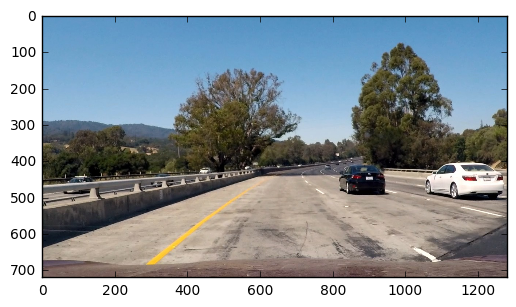

In [7]:
test1 = mpimg.imread('./test_images/test1.jpg')
plt.imshow(test1)

In [34]:
windows = slide_window(test1)

In [36]:
imgs = []
for window in windows:
    #3) Extract the test window from original image
    test_img = cv2.resize(test1[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
    imgs.append(test_img)

In [39]:
imgs = np.array(imgs)

In [42]:
imgs_normed = imgs/255.

In [43]:
cars_pred = np.argmax(model.predict(imgs_normed), axis=1)

In [47]:
cars_windows_idx = np.nonzero(cars_pred > 0)

In [60]:
boxes = []
for i in cars_windows_idx[0]:
    boxes.append(windows[i])

In [62]:
outimg = draw_boxes(test1, boxes)

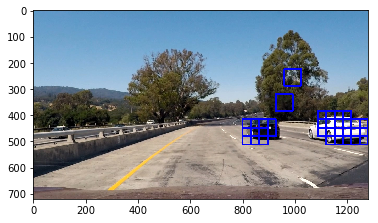

In [63]:
plt.imshow(outimg)

In [13]:
def define_multiscale_window(img):
    y_start_stop = [int(0.5 * img.shape[0]), img.shape[0] -50]
    y_start_stop_small = [int(0.5 * img.shape[0]), int(0.7 * img.shape[0])]
    y_start_stop_med = [int(0.5 * img.shape[0]), int(0.8 * img.shape[0])]
    windowsizes = [32,64,128, 256]
    
    windows_small = slide_window(img, y_start_stop=y_start_stop_small, 
                    xy_window=(32, 32))
    windows_small2 =  slide_window(img, y_start_stop=y_start_stop_med, 
                    xy_window=(64, 64))
    windows_large1  =  slide_window(img, y_start_stop=y_start_stop, 
                    xy_window=(128,128))
#     windows_large2 =  slide_window(img, y_start_stop=y_start_stop, 
#                     xy_window=(200,200))
    return windows_small + windows_small2 + windows_large1 #+ windows_large2

In [14]:
def get_hot_boxes(img, windows, model):
    imgs = []
    for window in windows:
        test_img = cv2.resize(test1[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        imgs.append(test_img)
    imgs = np.array(imgs)
    imgs_normed = imgs/255.
    cars_pred = np.argmax(model.predict(imgs_normed), axis=1)
    cars_windows_idx = np.nonzero(cars_pred > 0)
    boxes = []
    for i in cars_windows_idx[0]:
        boxes.append(windows[i])
    return boxes

In [15]:
multiwindows = define_multiscale_window(test1)

In [16]:
outimg2 =get_hot_boxes(test1, multiwindows, model)

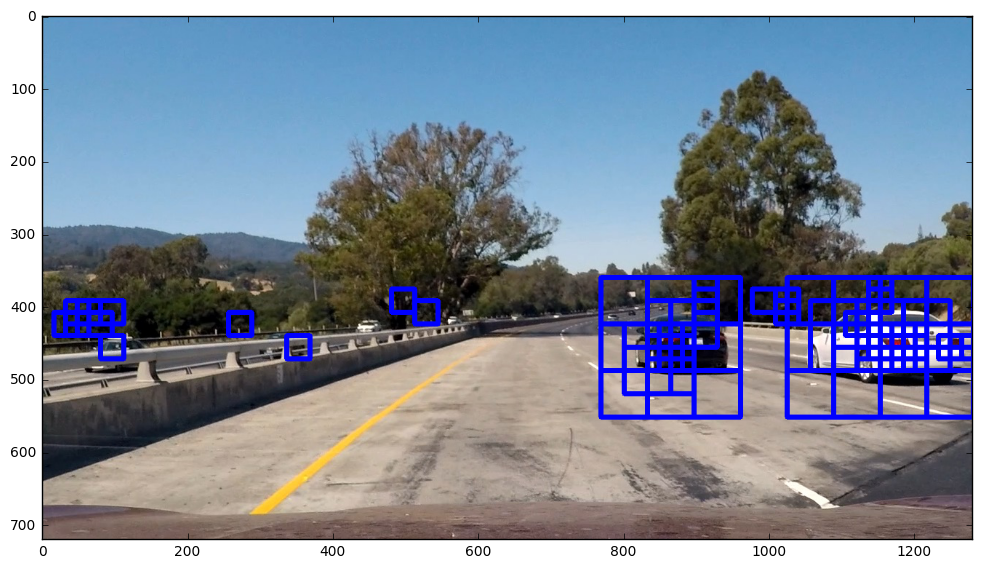

In [17]:
plt.figure(figsize=(12,8))
plt.imshow(draw_boxes(test1, outimg2))

In [ ]:
plt.figure(figsize=(12,8))
plt.imshow(draw_boxes(test1, outimg2))
outimg2 =get_hot_boxes(test1, multiwindows, model)

In [16]:
model = MobileNet(weights = "imagenet",include_top=False,input_shape = (224, 224, 3))

17227776/17225924 [==============================] - 9s 1us/step


In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 32)      0         
__________

In [ ]:
last_conv = model.get_layer('conv_pw_13_relu').output
flatten = Flatten(last_conv)
fc1 = Dense(flatten)
fc2 = Dense(fc1)
prediction = Dense(output_dim=1, activation='sigmoid', name='logit')(fc2)
model_modified = Model(input=model.input, output=prediction)
model_modified.summary()

In [ ]:
# generator for producing training/validation data in batches so there is no need to hold all of
#  the training data in memory-- given the sample size, the machine would actually run out of memory if I use
# all three training datasets (sample driving data, my driving data, and the reverse driving)
def img_generator(samples, batch_size=32, is_validation_generator = False):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []

            for batch_sample in batch_samples:
                steering_angle = float(batch_sample[3])

                center_image = cv2.imread(batch_sample[0])
                images.append(cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB))
                angles.append(steering_angle)

                images.append(np.fliplr(center_image))
                angles.append(steering_angle * - 1.0)

                # the validation data shouldn't have the extra left/ right or the reversed images as
                # at testing time only data from central camera is used
                if (is_validation_generator == False and batch_sample[1].split('/')[0] != 'data_recovery') :
                    left_image = cv2.imread(batch_sample[1])
                    right_image = cv2.imread(batch_sample[2])


                    if batch_sample[1].split('/')[0] == 'data_reverse':
                        images.append(cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB))
                        angles.append(steering_angle + 0.005 * steering_angle)

                        images.append(cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB))
                        angles.append(steering_angle - 0.008 * steering_angle)

                    else :
                        images.append(cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB))
                        angles.append(steering_angle + 0.01 * steering_angle)

                        images.append(cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB))
                        angles.append(steering_angle - 0.005 * steering_angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [48]:
x = Input(shape=(224,224,3))
# This works, and returns the 10-way softmax we defined above.
y = model(x)
y2 = Dense(2, activation='softmax')(y)

In [ ]:
batch_size = 32
batches = datagen.flow(X_train, y_train, batch_size=batch_size, target_size=(224,224), shuffle=True)
val_batches = gen.flow(X_test, y_test, batch_size=batch_size, target_size=(224,224), shuffle=False)